# 🔥 1D Heat Equation with Boundary and Initial Conditions

We consider the one-dimensional heat equation:

$$
\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2}, \quad x \in [0, 1], \quad t > 0
$$

## Initial Condition:
$$
u(x, 0) = \sin(\pi x)
$$

## Boundary Conditions:
$$
u(0, t) = 0, \quad u(1, t) = 0 \quad \text{for all } t \geq 0
$$

---

# ✅ Exact Solution:
The analytical solution to this problem is:

$$
u(x, t) = \sin(\pi x) \cdot e^{-\pi^2 t}
$$

This solution:
- Satisfies the heat equation
- Fulfills the boundary conditions $u(0,t) = u(1,t) = 0$
- Matches the initial condition $u(x,0) = \sin(\pi x)$

---

# 📌 Notes:
- The solution describes how heat diffuses along a 1D rod of length 1 with ends kept at zero temperature.
- The temperature decays exponentially over time due to the $e^{-\pi^2 t}$ factor.


In [1]:
# Heat Equation PINN
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc

In [2]:
# Set default dtype and device
torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Define the PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1)
        )
    def forward(self, x, t):
        input = torch.cat([x, t], dim=1)
        return self.net(input)
model = PINN()

In [4]:
model

PINN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Tanh()
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [6]:
# Count total nn.Linear layers
linear_layers = sum(1 for layer in model.modules() if isinstance(layer, nn.Linear))
print("Total nn.Linear layers:", linear_layers)

Total nn.Linear layers: 4


In [9]:
# PDE residual function for 1D Heat Equation: u_t = u_xx
def heat_pde(u, x, t):
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return u_t - u_xx

In [10]:
# Initial and boundary conditions
def initial_condition(x):
    return torch.sin(np.pi * x)

#def boundary_condition(t):
def boundary_condition_left(t):
    return torch.zeros_like(t)  # u(0, t) = 0

def boundary_condition_right(t):
    return torch.zeros_like(t)  # u(L, t) = 0

In [39]:
# Training data parameters
N_f = 250000  # Collocation points
N_u = 2000    # Initial condition points
N_b = 2000    # Boundary condition points

# collocation points
sampler = qmc.LatinHypercube(d=2)
lhs_samples = sampler.random(n=N_f)

In [40]:
lhs_samples.shape

(250000, 2)

In [41]:
# Keep both x and t in [0, 1]
x_f = lhs_samples[:, [0]]
t_f = lhs_samples[:, [1]]
print(x_f.shape)
print(t_f.shape)

(250000, 1)
(250000, 1)


In [18]:
t_f.shape

(250000, 1)

In [42]:
# Initial condition points: x in [0, 1], t = 0
x_u = torch.linspace(0, 1, N_u, device=device).unsqueeze(1)
t_u = torch.zeros_like(x_u)
u_u = initial_condition(x_u)

In [43]:
print(x_u, t_u, u_u)

tensor([[0.0000e+00],
        [5.0025e-04],
        [1.0005e-03],
        ...,
        [9.9900e-01],
        [9.9950e-01],
        [1.0000e+00]], device='cuda:0') tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], device='cuda:0') tensor([[ 0.0000e+00],
        [ 1.5716e-03],
        [ 3.1432e-03],
        ...,
        [ 3.1432e-03],
        [ 1.5716e-03],
        [-8.7423e-08]], device='cuda:0')


In [22]:
print(x_u.shape, t_u.shape, u_u.shape)

torch.Size([2000, 1]) torch.Size([2000, 1]) torch.Size([2000, 1])


In [44]:
# Boundary condition points: x = 0 and x = 1, t in [0, 1]
t_b = torch.linspace(0, 1, N_b, device=device).unsqueeze(1)
x_b1 = torch.zeros_like(t_b)
x_b2 = torch.ones_like(t_b)
u_b1 = boundary_condition_left(t_b)
u_b2 = boundary_condition_right(t_b)

In [31]:
print(t_b.shape, x_b1.shape, x_b2.shape, u_b1.shape ,u_b2.shape)

torch.Size([2000, 1]) torch.Size([2000, 1]) torch.Size([2000, 1]) torch.Size([2000, 1]) torch.Size([2000, 1])


In [45]:
# Model and optimizeri
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [58]:
# Track losses
loss_history = []
loss_ic_history = []
loss_bc_history = []
loss_pde_history = []

In [47]:
print(x_u.shape, t_u.shape)
print(x_b1.shape, t_b.shape)
print(x_b2.shape, t_b.shape)

torch.Size([2000, 1]) torch.Size([2000, 1])
torch.Size([2000, 1]) torch.Size([2000, 1])
torch.Size([2000, 1]) torch.Size([2000, 1])


In [51]:
x_b1.dtype

torch.float32

In [52]:
# NEW
x_f = torch.tensor(x_f, dtype=torch.float32, device=device)
t_f = torch.tensor(t_f, dtype=torch.float32, device=device)

<ipython-input-52-81d483944cb6>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_f = torch.tensor(x_f, dtype=torch.float32, device=device)
<ipython-input-52-81d483944cb6>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_f = torch.tensor(t_f, dtype=torch.float32, device=device)


In [55]:
x_f.requires_grad = True
t_f.requires_grad = True

In [59]:
# Training loop with Adam
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()

    u_pred_u = model(x_u, t_u)
    u_pred_b1 = model(x_b1, t_b)
    u_pred_b2 = model(x_b2, t_b)
    u_pred_f = model(x_f, t_f)

    # print(u_pred_u.shape, u_pred_b1.shape, u_pred_b2.shape, u_pred_f.shape)
    f_pred = heat_pde(u_pred_f, x_f, t_f)

    loss_ic = torch.mean((u_pred_u - u_u)**2)
    loss_bc = torch.mean((u_pred_b1 - u_b1)**2) + torch.mean((u_pred_b2 - u_b2)**2)
    loss_pde = torch.mean(f_pred**2)

    loss = loss_ic + loss_bc + loss_pde
    loss.backward()
    optimizer.step()

    # Log losses
    loss_history.append(loss.item())
    loss_ic_history.append(loss_ic.item())
    loss_bc_history.append(loss_bc.item())
    loss_pde_history.append(loss_pde.item())

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.8f}")

Epoch 0, Loss: 0.00788758
Epoch 1000, Loss: 0.00049650
Epoch 2000, Loss: 0.00022245
Epoch 3000, Loss: 0.00013854
Epoch 4000, Loss: 0.00009529
Epoch 5000, Loss: 0.00012202
Epoch 6000, Loss: 0.00005227
Epoch 7000, Loss: 0.00004133
Epoch 8000, Loss: 0.00003390
Epoch 9000, Loss: 0.00002949


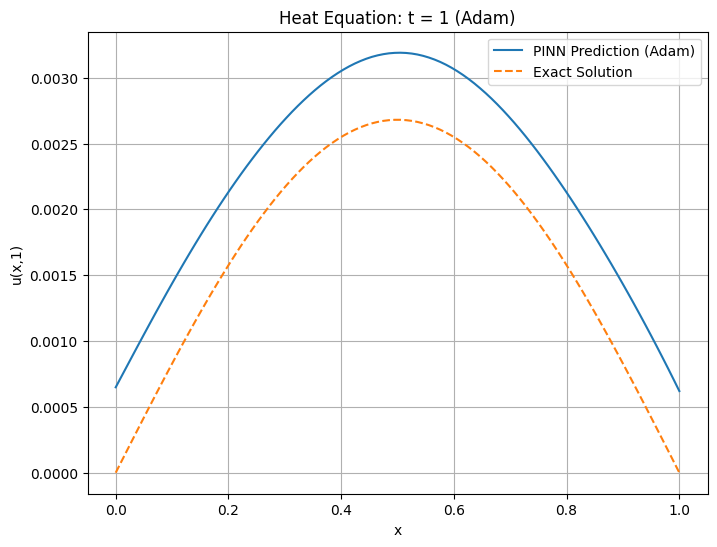

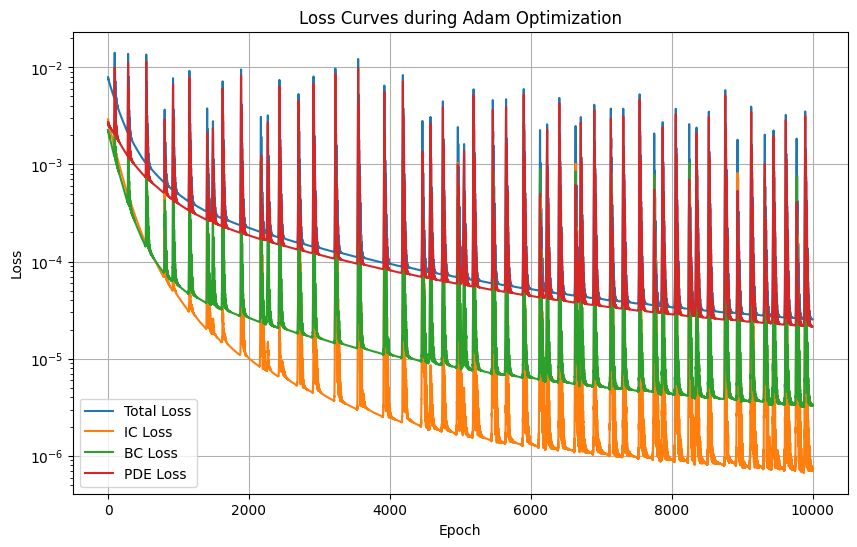

u_pred_adam    u_exact
------------------------


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [60]:
# Plot prediction vs exact after Adam
x_eval = torch.linspace(0, 1, 100).unsqueeze(1).to(device)
t_eval = torch.ones_like(x_eval) * 0.6
u_pred_adam = model(x_eval, t_eval).detach().cpu().numpy()
u_exact = np.sin(np.pi * x_eval.cpu().numpy()) * np.exp(-np.pi**2 * 0.6)

plt.figure(figsize=(8,6))
plt.plot(x_eval.cpu(), u_pred_adam, label='PINN Prediction (Adam)')
plt.plot(x_eval.cpu(), u_exact, '--', label='Exact Solution')
plt.legend()
plt.title('Heat Equation: t = 1 (Adam)')
plt.xlabel('x')
plt.ylabel('u(x,1)')
plt.grid(True)
plt.show()

# Plot loss curves after Adam
plt.figure(figsize=(10,6))
plt.plot(loss_history, label='Total Loss')
plt.plot(loss_ic_history, label='IC Loss')
plt.plot(loss_bc_history, label='BC Loss')
plt.plot(loss_pde_history, label='PDE Loss')
plt.yscale('log')
plt.title('Loss Curves during Adam Optimization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
print("u_pred_adam    u_exact")
print("------------------------")
for pred, exact in zip(u_pred_adam, u_exact):
    print(f"{pred:<14.8f}{exact:<.8f}")

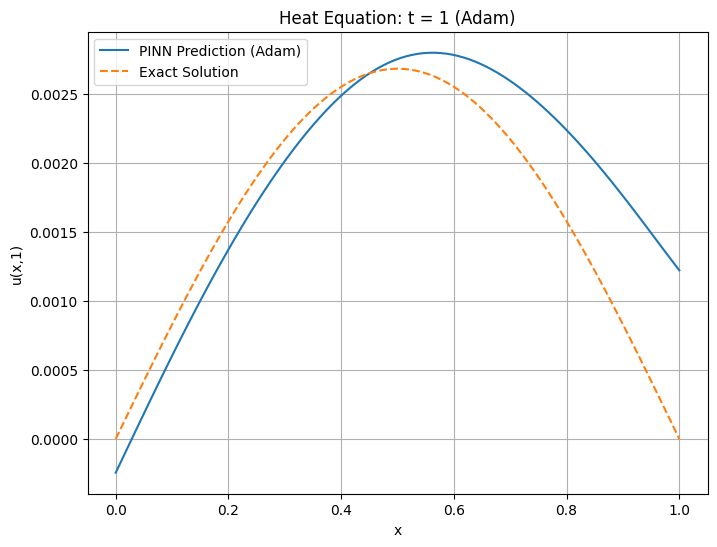

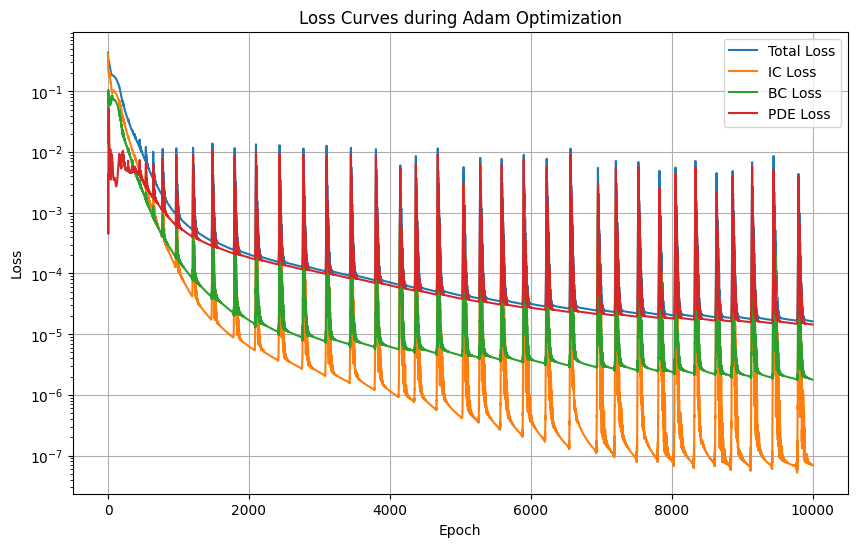

u_pred_adam    u_exact
------------------------


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [61]:
# -------------------------- L-BFGS Refinement --------------------------
optimizer_lbfgs = torch.optim.LBFGS(model.parameters(),
                                    max_iter=5000,
                                    max_eval=5000,
                                    tolerance_grad=1e-8,
                                    tolerance_change=1e-8,
                                    history_size=50,
                                    line_search_fn='strong_wolfe')

loss_lbfgs_history = []

# Define closure function
def closure():
    optimizer_lbfgs.zero_grad()

    u_pred_u = model(x_u, t_u)
    u_pred_b1 = model(x_b1, t_b)
    u_pred_b2 = model(x_b2, t_b)
    u_pred_f = model(x_f, t_f)

    f_pred = heat_pde(u_pred_f, x_f, t_f)

    loss_ic = torch.mean((u_pred_u - u_u)**2)
    loss_bc = torch.mean((u_pred_b1 - u_b1)**2) + torch.mean((u_pred_b2 - u_b2)**2)
    loss_pde = torch.mean(f_pred**2)

    loss = loss_ic + loss_bc + loss_pde
    loss.backward()

    # Optional: print every 50 iterations
    if len(loss_lbfgs_history) % 50 == 0:
        print(f"L-BFGS Iteration {len(loss_lbfgs_history)}: Loss = {loss.item()}")

    loss_lbfgs_history.append(loss.item())
    return loss

# Run L-BFGS optimization
print("Training with L-BFGS...")
optimizer_lbfgs.step(closure)
print("L-BFGS Optimization Completed!")

# Print final loss
print(f"Final L-BFGS Loss: {loss_lbfgs_history[-1]}")

Training with L-BFGS...
L-BFGS Iteration 0: Loss = 2.547708572819829e-05
L-BFGS Optimization Completed!
Final L-BFGS Loss: 2.54632395808585e-05


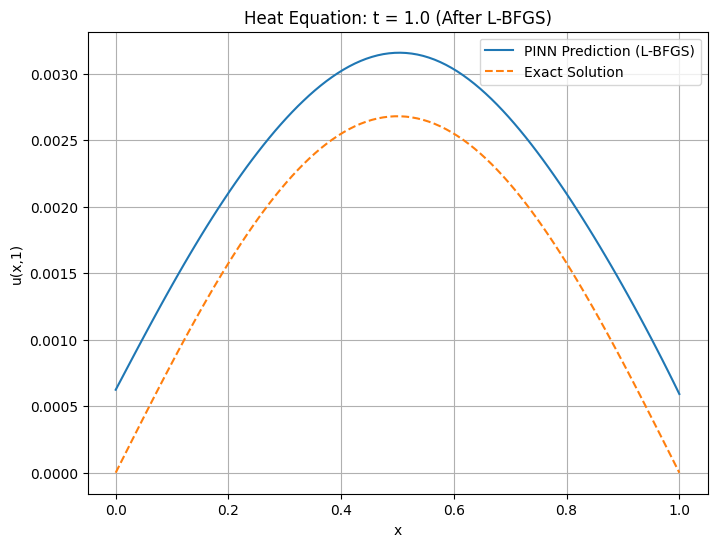

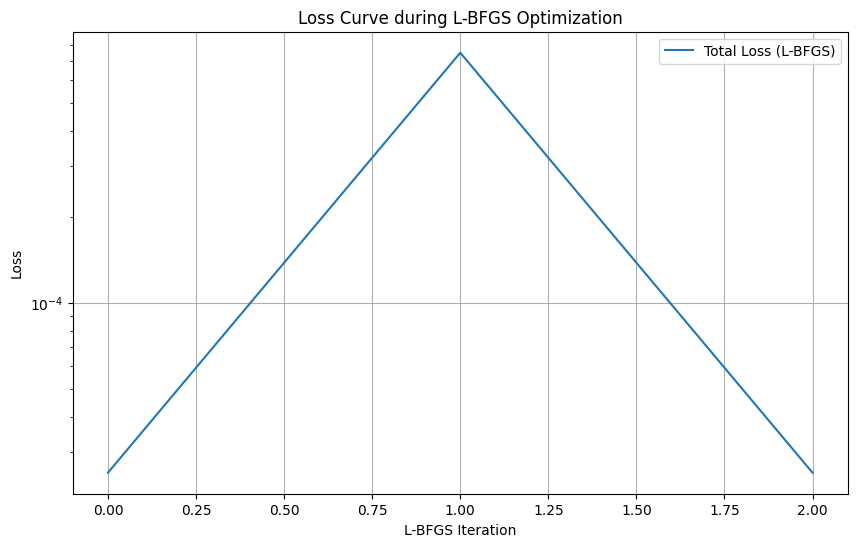

In [62]:
# Plot prediction vs exact after L-BFGS
u_pred_lbfgs = model(x_eval, t_eval).detach().cpu().numpy()

plt.figure(figsize=(8,6))
plt.plot(x_eval.cpu(), u_pred_lbfgs, label='PINN Prediction (L-BFGS)')
plt.plot(x_eval.cpu(), u_exact, '--', label='Exact Solution')
plt.legend()
plt.title('Heat Equation: t = 1.0 (After L-BFGS)')
plt.xlabel('x')
plt.ylabel('u(x,1)')
plt.grid(True)
plt.show()

# Plot loss curve after L-BFGS
plt.figure(figsize=(10,6))
plt.plot(loss_lbfgs_history, label='Total Loss (L-BFGS)')
plt.yscale('log')
plt.title('Loss Curve during L-BFGS Optimization')
plt.xlabel('L-BFGS Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()